In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))
print(sys.path)

# load test dataset
from torch.utils.data import DataLoader
import json

import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T
import json

from tasks.seq_mnist import SeqMNISTModelTraining_ntm, SeqMNISTParams_ntm, SeqMNISTModelTraining_lstm, SequentialMNIST
import json
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

['/Users/kerekmen/miniconda3/envs/s4/lib/python39.zip', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.9', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.9/lib-dynload', '', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.9/site-packages', '/Users/kerekmen/Studium/Master/Semester2/NN-module/nn-seminar']


/Users/kerekmen/miniconda3/envs/s4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


## Plot losses

Sequence Length: 64


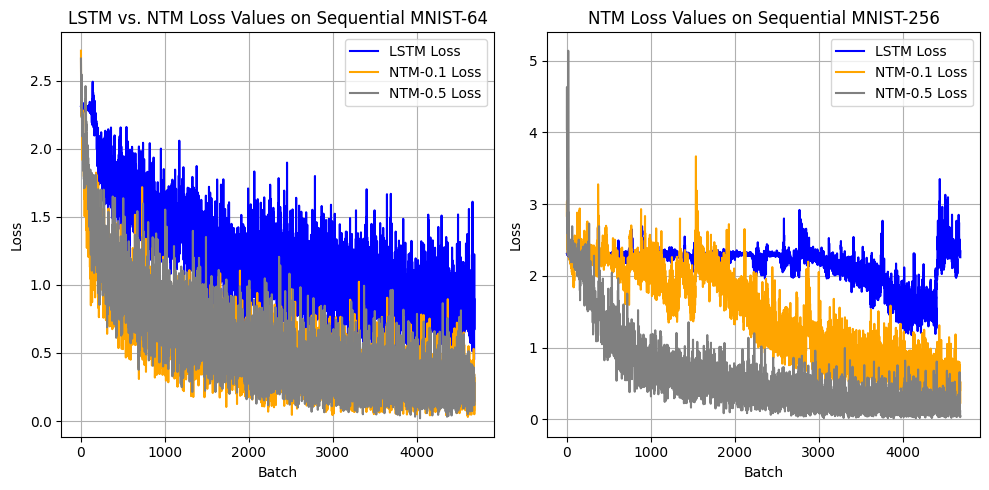

In [2]:

# 8*8 sequence length
lstm_path_json = '../checkpoints/2024-06-1114-14-10/seq-mnist-lstm-64/seq-mnist-lstm--seed-1000-epoch-5-batch-937-2024-06-1114-14-10.json'
ntm_path_json = '../checkpoints/2024-06-1114-14-32/seq-mnist-ntm-64/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1114-14-32.json'
ntm_path_json2 = '../checkpoints/2024-06-1114-42-18/seq-mnist-ntm-64/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1114-42-18.json'
ntm_path_json3 = '../checkpoints/2024-06-1116-14-11/seq-mnist-ntm-64/seq-mnist-ntm--seed-1000-epoch-4-batch-360-2024-06-1116-14-11.json'

lstm_path_pt = os.path.splitext(lstm_path_json)[0] + '.pth'
ntm_path_pt = os.path.splitext(ntm_path_json)[0] + '.pth'
ntm_path_pt2 = os.path.splitext(ntm_path_json2)[0] + '.pth'
ntm_path_pt3 = os.path.splitext(ntm_path_json3)[0] + '.pth'

# 16 * 16 sequence length
ntm_path_json_256 = '../checkpoints/seq-mnist-ntm--seed-1000-epoch-3-batch-937-2024-06-1116-15-07.json'
lstm_path_json_256 = "../checkpoints/2024-06-1122-24-07/seq-mnist-lstm-256/seq-mnist-lstm--seed-1000-epoch-5-batch-937-2024-06-1122-24-07.json"
ntm_path_json_256_2 = "../checkpoints/2024-06-1200-31-35/seq-mnist-ntm-256/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1200-31-35.json"
ntm_path_json_256_3 = "../checkpoints/seq-mnist-ntm--seed-1000-epoch-5-batch-937-2024-06-1123-35-46.json"

# Load the loss data from the JSON file
with open(lstm_path_json) as f:
    data_lstm = json.load(f)
with open(ntm_path_json) as f:
    data_ntm = json.load(f)
with open(ntm_path_json2) as f:
    data_ntm2 = json.load(f)
with open(ntm_path_json3) as f:
    data_ntm3 = json.load(f)
with open(ntm_path_json_256) as f:
    data_ntm_256 = json.load(f)
with open(lstm_path_json_256) as f:
    data_lstm_256 = json.load(f)
with open(ntm_path_json_256_2) as f:
    data_ntm_256_2 = json.load(f)
with open(ntm_path_json_256_3) as f:
    data_ntm_256_3 = json.load(f)

loss_lstm = data_lstm['loss']
loss_ntm = data_ntm['loss']
loss_ntm2 = data_ntm2['loss']
loss_ntm3 = data_ntm3['loss']
loss_ntm_256 = data_ntm_256['loss']
loss_lstm_256 = data_lstm_256['loss']
loss_ntm_256_2 = data_ntm_256_2['loss']
loss_ntm_256_3 = data_ntm_256_3['loss']

resolution = data_lstm["parameters_model"]["resize_resolution"]
sequence_len = resolution**2
print(f"Sequence Length: {sequence_len}")

# Define the window size for the rolling average
window_size = 400

# Adjust x to match the length of loss_avg
x_lstm = np.arange(len(loss_lstm))
x_ntm = np.arange(len(loss_ntm))
x_ntm2 = np.arange(len(loss_ntm2))
x_ntm3 = np.arange(len(loss_ntm3))

x_ntm_256 = np.arange(len(loss_ntm_256))
x_lstm_256 = np.arange(len(loss_lstm_256))
x_ntm_256_2 = np.arange(len(loss_ntm_256_2))
x_ntm_256_3 = np.arange(len(loss_ntm_256_3))


# Plot for sequence length 64
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].plot(x_lstm, loss_lstm, label='LSTM Loss', color='blue')
axs[0].plot(x_ntm, loss_ntm, label=f'NTM-{data_ntm["parameters_model"]["use_memory"]} Loss', color='orange')
axs[0].plot(x_ntm2, loss_ntm2, label=f'NTM-{data_ntm2["parameters_model"]["use_memory"]} Loss', color='grey')
# axs[0].plot(x_ntm3, loss_ntm3, label=f'NTM-{data_ntm3["parameters_model"]["use_memory"]} Loss', color='green')

axs[0].set_title(f'LSTM vs. NTM Loss Values on Sequential MNIST-{data_lstm["parameters_model"]["seq_len"]}')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for sequence length 256
axs[1].plot(x_lstm_256, loss_lstm_256, label='LSTM Loss', color='blue')
# axs[1].plot(x_ntm_256, loss_ntm_256, label=f'NTM-{data_ntm_256["parameters_model"]["use_memory"]} Loss', color='orange')
axs[1].plot(x_ntm_256_3, loss_ntm_256_3, label=f'NTM-{data_ntm_256_3["parameters_model"]["use_memory"]} Loss', color='orange')
axs[1].plot(x_ntm_256_2, loss_ntm_256_2, label=f'NTM-{data_ntm_256_2["parameters_model"]["use_memory"]} Loss', color='grey')
axs[1].set_title('NTM Loss Values on Sequential MNIST-256')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Plot Validation Accuracy

Sequence Length: 64


<Figure size 1000x600 with 0 Axes>

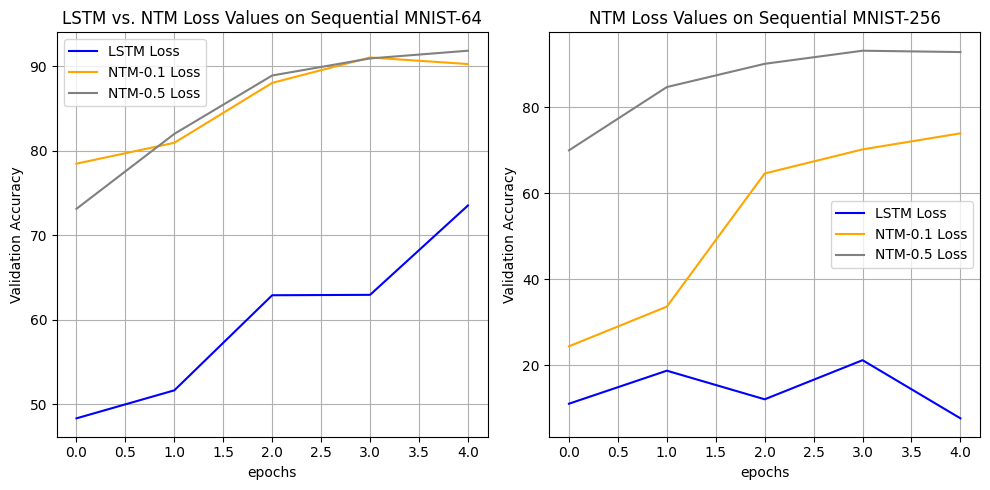

In [17]:
val_lstm = data_lstm['val_accuracy_list']
val_ntm = data_ntm['val_accuracy_list']
val_ntm2 = data_ntm2['val_accuracy_list']
val_ntm3 = data_ntm3['val_accuracy_list']

val_ntm_256 = data_ntm_256['val_accuracy_list']
val_ntm_256_2 = data_ntm_256_2['val_accuracy_list']
val_lstm_256 = data_lstm_256['val_accuracy_list']

resolution = data_lstm["parameters_model"]["resize_resolution"]
sequence_len = resolution**2
print(f"Sequence Length: {sequence_len}")

# Define the window size for the rolling average
window_size = 400

# Adjust x to match the length of loss_avg
x_lstm = np.arange(len(val_lstm))
x_ntm = np.arange(len(val_ntm))
x_ntm2 = np.arange(len(val_ntm2))
x_ntm3 = np.arange(len(val_ntm3))

x_ntm_256 = np.arange(len(val_ntm_256))
x_ntm_256_2 = np.arange(len(val_ntm_256_2))
x_lstm_256 = np.arange(len(val_lstm_256))

# plot both lstm and ntm losses on squential mnist
plt.figure(figsize=(10, 6))

# Plot for sequence length 64
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].plot(x_lstm, val_lstm, label='LSTM Loss', color='blue')
axs[0].plot(x_ntm, val_ntm, label=f'NTM-{data_ntm["parameters_model"]["use_memory"]} Loss', color='orange')
axs[0].plot(x_ntm2, val_ntm2, label=f'NTM-{data_ntm2["parameters_model"]["use_memory"]} Loss', color='grey')
# axs[0].plot(x_ntm3, loss_ntm3, label=f'NTM-{data_ntm3["parameters_model"]["use_memory"]} Loss', color='green')

axs[0].set_title(f'LSTM vs. NTM Loss Values on Sequential MNIST-{data_lstm["parameters_model"]["seq_len"]}')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot for sequence length 256
axs[1].plot(x_lstm_256, val_lstm_256, label='LSTM Loss', color='blue')
axs[1].plot(x_ntm_256, val_ntm_256, label=f'NTM-{data_ntm_256["parameters_model"]["use_memory"]} Loss', color='orange')
axs[1].plot(x_ntm_256_2, val_ntm_256_2, label=f'NTM-{data_ntm_256_2["parameters_model"]["use_memory"]} Loss', color='grey')
axs[1].set_title('NTM Loss Values on Sequential MNIST-256')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# load test dataset
task_params = {
    "resize_resolution": resolution,
}
test_dataset = SequentialMNIST(task_params, train=False)

# load the model
lstm = SeqMNISTModelTraining_lstm()
ntm = SeqMNISTModelTraining_ntm()
lstm.net.load_state_dict(torch.load(lstm_path_pt))
ntm.net.load_state_dict(torch.load(ntm_path_pt))
print(len(test_dataset))

# Run evaluation

In [ ]:
from tqdm import tqdm

print(f"Number of samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False, )

dict_model = {
    "LSTM": lstm,
    "NTM": ntm
}

for model_name in dict_model:
    print(f"Testing model: {model_name}")
    model = dict_model[model_name]
    model.net.eval()
    correct = 0
    total = 0
    for i, (X, Y) in enumerate(tqdm(test_loader)):
        X = X.permute(1, 0, 2)
        Y = Y.squeeze(1)
        
        batch_size = X.size(1)
        if model_name == "NTM":
            model.net.init_sequence(batch_size)

        # Forward pass
        if model_name == "LSTM":
            y_out = model.net(X)
        else:
            for j in range(X.size(0)):
                y_out, _ = model.net(X[j])
        
        _, predicted = torch.max(y_out.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")